In [8]:
# top_logprobs
import sys 
sys.path.append("/home/flowers/work/OpenELM")
from openai import AzureOpenAI
from key import OPENAI_API_KEY,cfg_client_azure,cfg_client_azure_gpt4
from utils import get_multiple_completions
import json
import copy
import matplotlib.pyplot as plt
import numpy as np
cfg_client= copy.deepcopy(cfg_client_azure)
model_id=cfg_client["model_id"]

cfg_client_gpt4= copy.deepcopy(cfg_client_azure_gpt4)

model_id_gpt4=cfg_client_gpt4["model_id"]

del cfg_client["model_id"]
del cfg_client_gpt4["model_id"]
cfg: dict = {
"temperature": 0.7,
"max_tokens":500,
# "top_p": 1.,
# TODO: rename config option?
"model": model_id,
# "logprobs": True,
# "top_logprobs": 5,ez
}
cfg_gpt4 = copy.deepcopy(cfg)
cfg_gpt4["model"]=model_id_gpt4
max_retries=10
timeout=30
client = AzureOpenAI(**cfg_client,max_retries=max_retries, timeout=timeout)
client_gpt4= AzureOpenAI(**cfg_client_gpt4,max_retries=max_retries, timeout=timeout)
import instructor
client_instructor=instructor.patch(client)
client_instructor_gpt4=instructor.patch(client_gpt4)
path = "/home/flowers/work/OpenELM/analysis_P3/generation/puzzle_survey_v2.json"
with open(path) as f:
    data=json.load(f)

list_puzzle=[i['formatted'] for i in data]

In [21]:
n=260
t=1
s=10.25
m=n*t*s*4/3
c=0.8580
m,m*c #(3553.3333333333335, 3048.76)


(3553.3333333333335, 3048.76)

In [24]:
512+128*4



1024

# based on questionnary

In [5]:
min_grade=1
max_grade=7
interval=f"{min_grade}-{max_grade}"
grades="""**Clarity**: we want to understand whether the programming puzzle’s instructions were clear. Clear instructions provide all the necessary information to solve the puzzle concisely and unambiguously.
How clear were the instructions?
- {interval} Likert from not clear at all to very clear 

**Usefulness for skill learning**: we want to understand how much {level} would benefit from practicing on this puzzle. A student benefits from a puzzle if it is adequate to their current level of skills – i.e., if it is not too easy (since the student would not learn anything new) and not too hard (since the student would not be able to even make progress on the puzzle). 
How much would an advanced student benefit from practicing on this puzzle? 
- {interval} Likert from not at all to very much

**Difficulty**: we want to understand how difficult this puzzle would be for {level}. 
How difficult would it be for {level} to solve this puzzle? 
- {interval} Likert from not at all difficult (could solve it very easily) to very difficult (takes a long time to solve and/or may not be possible for the student to solve)

**Engagement**: we want to understand how engaging, interesting, or fun this puzzle would be for {level}.
How engaging would {level} find this puzzle? 
- {interval} Likert from not at all engaging to very engaging

**Conciseness of the solution**: we want to know how likely the problem is to have a concise solution. A concise solution would have <10 lines of code and it would not be too hard to follow using pen and paper.
How likely is this puzzle to support at least one concise solution?
- {interval} Likert from not at all likely to very likely

**Overall recommendation**: Imagine you were teaching a programming class. We want to understand whether you would recommend this puzzle to {level}.  
Would you recommend this puzzle to {level}?
- {interval} Likert from would never recommend to would strongly recommend
"""
level_advance = "a last year bachelor student"#"an expert in Leetcode problems"
level_beginner = "a first year bachelor student"
grades_level=grades.format(interval=interval,level=level_advance)


In [6]:
lvl_="first-year bachelor student"
preprompt_2=f'''You are a discerning and objective assistant tasked with evaluating Python Programming Puzzles for {lvl_}. Your role is crucial in ensuring the puzzle's grads is accurately gauged to maintain the integrity of our educational process.

Each puzzle should be rated on a Likert scale from {min_grade} to {max_grade}, where:
- A score of {min_grade} signifies unlikely or not at all.
- A score of {max_grade} indicates very likely or very much.

We encourage you to utilize the full range of the scale to differentiate between the levels of grading effectively.''' 
# Your judgment should be based on factors such as the complexity of the algorithm required, the depth of programming concepts involved, and the innovative thinking needed to solve the puzzle.

# Please provide a score (an integer) that best represents the puzzle's difficulty. We rely on your expertise and judgment to use the entire scoring range appropriately to ensure a fair and accurate assessment.

# You must only give a score with the following format: "Score: "'''

## Question:
prompt_explain_puzzle='''Your role is to evaluate some programming puzzles in Python.
Each puzzle has two components:
- The problem function, denoted as f.
- The solution function, g.

The challenge lies in constructing g such that the expression f(g()) evaluates to True. In other words, each puzzle is a Python function that takes an answer as an argument. The answer is an input that makes the function return True.
'''
preprompt_1 = "You are an unbiased Judge and you have more than 10 years of experience in python programming."
preprompt= prompt_explain_puzzle
prompt = preprompt+"You need to evaluate the puzzle based on these criteria:\n"+grades_level+"\nHere is a puzzle for you to evaluate:\n```python\n{puzzle}\n```\n\n"

In [7]:
from openelm.mutation_model import get_multiple_completions_instructor
from pydantic import BaseModel,Field
from typing import List, Optional
class Puzzle_evalutation(BaseModel):
    f"""evaluate the given puzzle on a Likert scale from {interval}"""
    # explanations_grades: str = Field(decription="Short explanation of all specific grades that should be given to the puzzle.")
    evaluate_clarity: str = Field(description="quick evalution of the clarity .")
    clarity_grade: int = Field(description=f"{interval} Likert from not clear at all to very clear")
    evaluate_usefulness: str = Field(description="quick evalution of the usefulness for skill learning.")
    usefulness_grade: int = Field(description=f"{interval} Likert from not at all to very much")
    evaluate_difficulty: str = Field(description="quick evalution of the difficulty.")
    difficulty_grade: int = Field(description=f"{interval} Likert from not at all difficult to very difficult")
    evaluate_engagement: str = Field(description="quick evalution of the engagement.")
    engagement_grade: int = Field(description=f"{interval} Likert from not at all engaging to very engaging")
    evaluate_conciseness: str = Field(description="quick evalution of the conciseness of the solution.")
    conciseness_grade: int = Field(description=f"{interval} Likert from not at all likely to very likely")
    evaluate_overall_recommendation: str = Field(description="quick evalution of the overall recommendation.")
    overall_recommendation_grade: int = Field(description=f"{interval} Likert from would never recommend to would strongly recommend")

class Puzzle_evalutation(BaseModel):
    f"""evaluate the given puzzle on a Likert scale from {interval}"""
    # explanations_grades: str = Field(decription="Short explanation of all specific grades that should be given to the puzzle.")
    # evaluate_clarity: str = Field(description="quick evalution of the clarity .")
    clarity_grade: int = Field(description=f"{interval} Likert from not clear at all to very clear")
    # evaluate_usefulness: str = Field(description="quick evalution of the usefulness for skill learning.")
    usefulness_grade: int = Field(description=f"{interval} Likert from not at all to very much")
    # evaluate_difficulty: str = Field(description="quick evalution of the difficulty.")
    difficulty_grade: int = Field(description=f"{interval} Likert from not at all difficult to very difficult")
    # evaluate_engagement: str = Field(description="quick evalution of the engagement.")
    engagement_grade: int = Field(description=f"{interval} Likert from not at all engaging to very engaging")
    # evaluate_conciseness: str = Field(description="quick evalution of the conciseness of the solution.")
    conciseness_grade: int = Field(description=f"{interval} Likert from not at all likely to very likely")
    # evaluate_overall_recommendation: str = Field(description="quick evalution of the overall recommendation.")
    overall_recommendation_grade: int = Field(description=f"{interval} Likert from would never recommend to would strongly recommend")


In [8]:
list_prompt = [prompt.format(puzzle=i) for i in list_puzzle]
list_tools = [Puzzle_evalutation]*len(list_prompt)

In [9]:
# out = get_multiple_completions_instructor(client_instructor,list_prompt, cfg, list_tools)

out = get_multiple_completions_instructor(client_instructor_gpt4,list_prompt, cfg, list_tools)


100%|██████████| 15/15 [00:00<00:00, 254714.82it/s]


In [10]:
print(list_prompt[0])

Your role is to evaluate some programming puzzles in Python.
Each puzzle has two components:
- The problem function, denoted as f.
- The solution function, g.

The challenge lies in constructing g such that the expression f(g()) evaluates to True. In other words, each puzzle is a Python function that takes an answer as an argument. The answer is an input that makes the function return True.
You need to evaluate the puzzle based on these criteria:
**Clarity**: we want to understand whether the programming puzzle’s instructions were clear. Clear instructions provide all the necessary information to solve the puzzle concisely and unambiguously.
How clear were the instructions?
- 1-7 Likert from not clear at all to very clear 

**Usefulness for skill learning**: we want to understand how much a last year bachelor student would benefit from practicing on this puzzle. A student benefits from a puzzle if it is adequate to their current level of skills – i.e., if it is not too easy (since the 

In [121]:
# for i,(puz,grade) in enumerate((zip(list_puzzle,out))):
#     print('\n==================\n')
#     print('puzzle: ',i)
#     print('puzzle: ',puz)
#     print('\ngrade: ')
#     for k,v in grade.dict().items():
#         print(k,": ",v)


In [11]:
dic_grade={}
for key,v in out[0].dict().items():
    if "grade" in key:
        dic_grade[key]=[]
for i in range(len(out)):
    for key,v in out[i].dict().items():
        if "grade" in key:
            dic_grade[key].append(v)

/tmp/ipykernel_6448/114370049.py:2: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  for key,v in out[0].dict().items():
/tmp/ipykernel_6448/114370049.py:6: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  for key,v in out[i].dict().items():


In [12]:
import matplotlib.pyplot as plt
import numpy as np


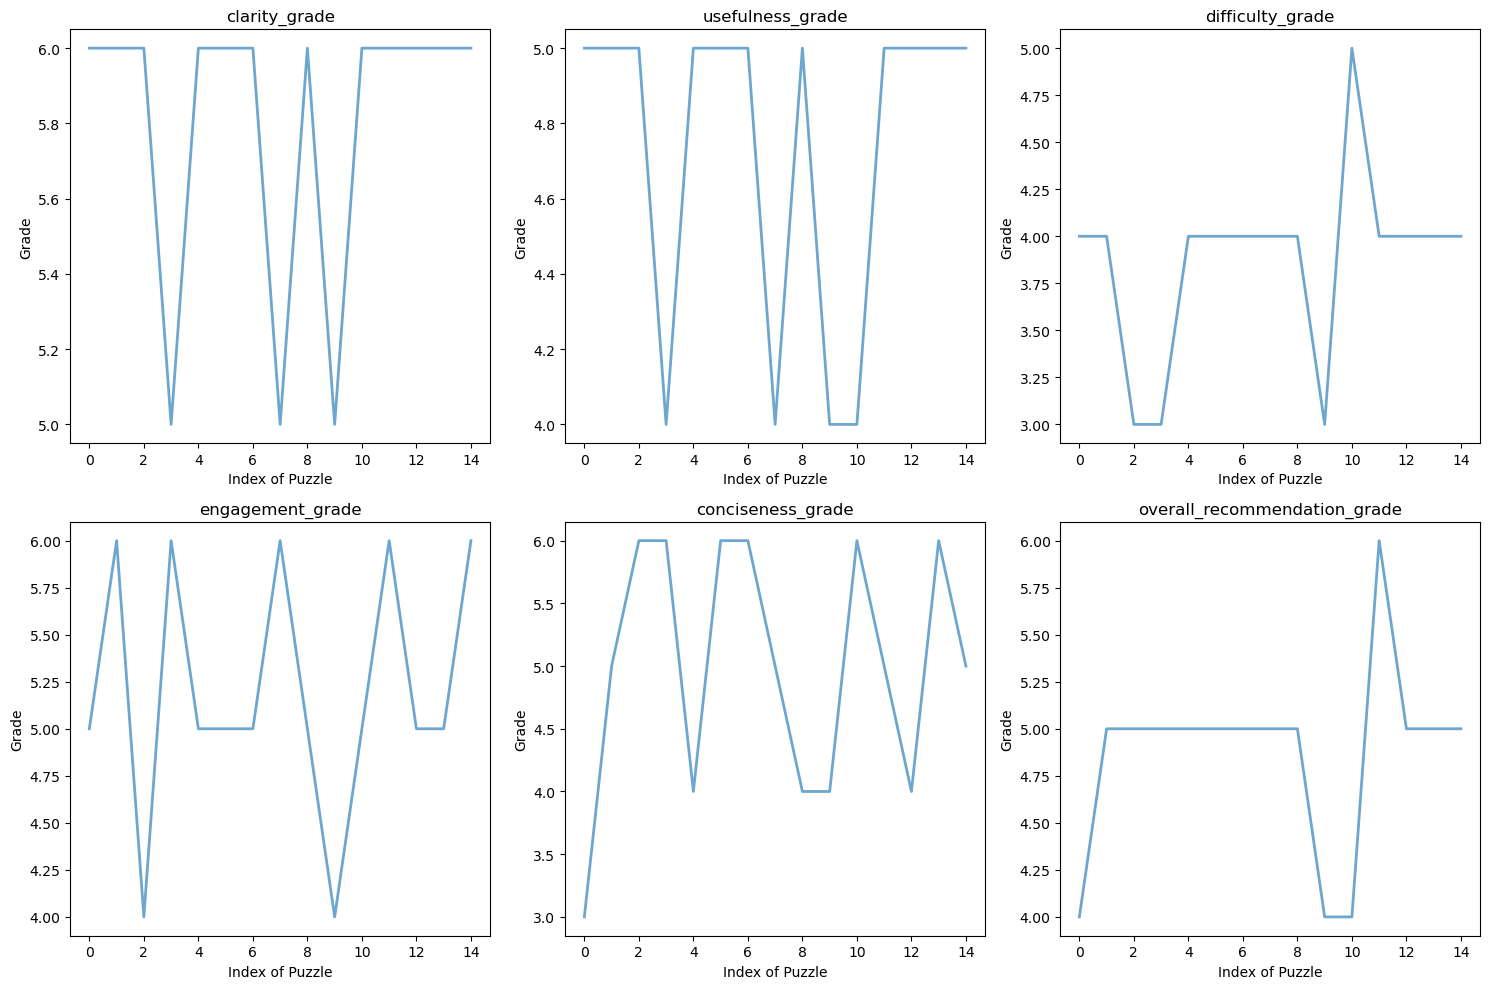

In [13]:
# Adjusting to a 2x3 layout as requested
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Flattening the ax for easier iteration
ax_flat = ax.flatten()

# Since we have more subplots (6) than students (3), we'll plot only 3 and leave the rest blank
for i, (key, v) in enumerate(dic_grade.items()):
    ax_flat[i].plot(v, linewidth=2 , alpha=0.65)
    ax_flat[i].set_title(key)
    ax_flat[i].set_xlabel('Index of Puzzle')
    ax_flat[i].set_ylabel('Grade')

# Hide the unused subplots
for i in range(len(dic_grade), len(ax_flat)):
    ax_flat[i].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()



Text(0, 0.5, 'N puzzles')

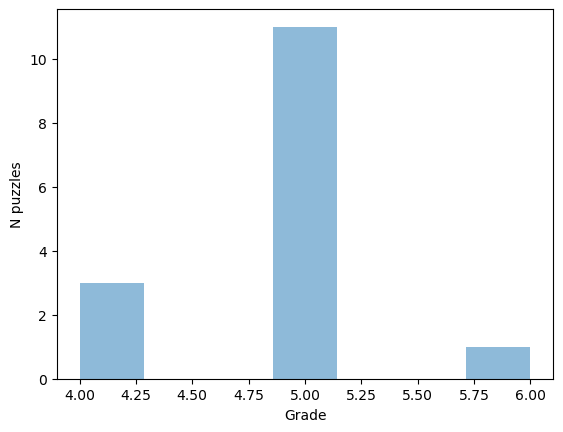

In [14]:
plt.hist(dic_grade['overall_recommendation_grade'], bins=7, alpha=0.5, label='overall_recommendation_grade')
plt.xlabel('Grade')
plt.ylabel('N puzzles')

In [126]:
# #overall_recommendation_grade,conciseness_grade,engagement_grade,difficulty_grade,usefulness_grade,clarity_grade
# for idx,grade in enumerate(dic_grade["engagement_grade"]):
#     print("\n =====================\n")
#     print("puzzle ",idx,f",grade = {grade}")
#     print()
#     print(list_puzzle[idx])

To adapt this questionnaire for an LLM like ChatGPT, it's important to tailor the questions towards an evaluation process that a machine learning model can perform, considering its understanding of textual information and its self-assessment capabilities. The focus should be on the model's ability to interpret the puzzle instructions, its estimation of the educational value of the puzzle for learners at different stages, and its overall assessment of the puzzle's quality based on the criteria provided.

### Clarity Assessment

1. On a scale of 1-7, how clear do you find the instructions of the programming puzzle, considering your ability to generate solutions based on the text?

### Usefulness for Skill Learning

2. For a beginner student, rate on a scale of 1-7 how beneficial practicing this puzzle would be, based on your understanding of their learning needs.
3. For an intermediate student, rate on a scale of 1-7 the potential benefits of practicing this puzzle, given your knowledge of what challenges can aid their progress.
4. For an advanced student, rate on a scale of 1-7 the usefulness of this puzzle for skill enhancement, considering your insight into their learning plateau.

### Difficulty Level

5. Estimate the difficulty level of this puzzle for a beginner student on a scale of 1-7, from your perspective on their problem-solving capabilities.
6. For an intermediate student, rate the difficulty level of solving this puzzle on a scale of 1-7, based on your assessment of their experience and skills.
7. For an advanced student, provide a difficulty rating on a scale of 1-7, considering your understanding of their advanced problem-solving skills.

### Engagement

8. Assess how engaging this puzzle would be for a beginner student on a scale of 1-7, from your analysis of what captivates learners at this stage.
9. Rate the engagement level of this puzzle for an intermediate student on a scale of 1-7, considering your insight into what stimulates learners with some experience.
10. Evaluate the engagement this puzzle would provide for an advanced student, rating it on a scale of 1-7 based on your understanding of what challenges and interests them.

### Support for Multiple Solutions

11. Based on your analysis, rate on a scale of 1-7 how likely this puzzle is to support several solutions of varying quality and efficiency.

### Conciseness of Solution

12. Rate the likelihood of the puzzle supporting at least one concise solution (defined as <10 lines of code) on a scale of 1-7, considering your computational understanding of efficiency and simplicity.

### Overall Recommendation

13. Would you recommend this puzzle to beginner students, intermediate students, and advanced students on a scale of 1-7, from "would never recommend" to "would strongly recommend"? Provide separate ratings based on your assessment of their respective skill levels.

This adaptation takes into account the LLM's perspective, enabling it to evaluate the programming puzzle based on its textual understanding and analytical capabilities.

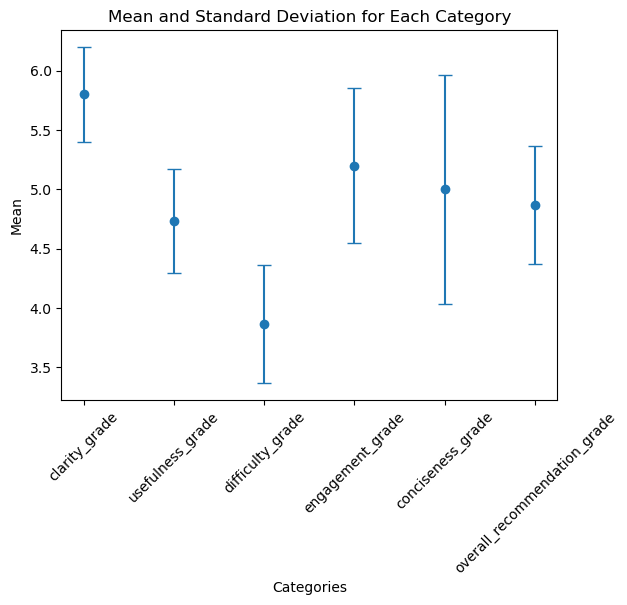

In [15]:

# plot mean std for each categories

# dic_grade= {'clarity_grade': [6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6],
#  'usefulness_grade': [5, 5, 5, 5, 4, 6, 5, 5, 5, 4, 5, 5, 5, 5, 5],
#  'difficulty_grade': [4, 4, 3, 4, 5, 5, 4, 4, 4, 3, 4, 4, 4, 4, 4],
#  'engagement_grade': [3, 6, 2, 6, 3, 6, 6, 6, 3, 2, 3, 6, 6, 6, 6],
#  'conciseness_grade': [6, 5, 6, 7, 6, 7, 5, 5, 6, 6, 6, 7, 5, 7, 7],
#  'overall_recommendation_grade': [5, 6, 4, 7, 5, 7, 6, 6, 5, 5, 5, 6, 6, 6, 7]}
mean_std={}
for key,v in dic_grade.items():
    mean_std[key]=(np.mean(v),np.std(v))
categories = list(dic_grade.keys())
means = [mean_std[category][0] for category in categories]
stds = [mean_std[category][1] for category in categories]


plt.errorbar(categories, means, yerr=stds, fmt='o', capsize=5)
plt.xticks(rotation=45)
plt.xlabel('Categories')
plt.ylabel('Mean')
plt.title('Mean and Standard Deviation for Each Category')
plt.show()


In [16]:
means,stds

([5.8, 4.733333333333333, 3.8666666666666667, 5.2, 5.0, 4.866666666666666],
 [0.39999999999999997,
  0.44221663871405337,
  0.49888765156985887,
  0.6531972647421808,
  0.9660917830792959,
  0.49888765156985887])

In [97]:
categories

['clarity_grade',
 'usefulness_grade',
 'difficulty_grade',
 'engagement_grade',
 'conciseness_grade',
 'overall_recommendation_grade']

(array([ 2.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,  1.]),
 array([6. , 6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6, 7.8, 8. ]),
 <BarContainer object of 10 artists>)

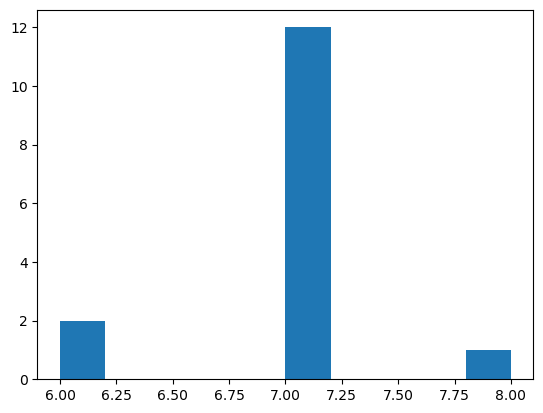

In [100]:
plt.hist(dic_grade["overall_recommendation_grade"])

# LAST STUFF

In [1]:
a=[{"c":1}]
a.append({"c":2})
a

[{'c': 1}, {'c': 2}]

In [3]:
import json
path="/home/flowers/work/OpenELM/analysis_P3/generation/p3_pb_dataset.json"
with open(path,"r") as f:
    data=json.load(f)

# for i in range(len(data)):
#     data[i]['program_str']= data[i]["instruction"] + "\n\n"+data[i]["completion"]

# with open(path,"w") as f:
#     json.dump(data,f,indent=4)

## prompt google

In [6]:
grades_wizard="""You are a discerning and objective assistant tasked with evaluating the difficulty and complexity of Python Programming Puzzles for candidates applying for a Google software engineer position. Your role is crucial in ensuring the puzzle's difficulty is accurately gauged to maintain the integrity of our evaluation process.

Each puzzle should be rated on a scale from 1 to 10, where:
- A score of 1 signifies a puzzle that is extremely straightforward, involving elementary operations (e.g., simple addition).
- A score of 10 denotes a puzzle of maximal difficulty and complexity, requiring advanced algorithmic problem-solving and deep understanding of Python programming concepts.

We encourage you to utilize the full range of the scale to differentiate between the levels of difficulty effectively. Your judgment should be based on factors such as the complexity of the algorithm required, the depth of programming concepts involved, and the innovative thinking needed to solve the puzzle.

Please provide a score (an integer) that best represents the puzzle's difficulty. We rely on your expertise and judgment to use the entire scoring range appropriately to ensure a fair and accurate assessment.

You must only give a score with the following format: "Score: "

## Question:
{puzzle}

## Score:
"""
def parse_score(s:str):
    score=-1
    try: 
        score = int(s.split(": ")[1])
    except:
        try:
            score = int(s)
        except:
            pass
        try:
            score = int((s.split(": ")[1]).split("\n")[0])
        except:
            pass
    return score
# list_prompt_wizard=[grades_wizard.format(puzzle=data[i]['program_str']) for i in range(len(data))]
# out=get_multiple_completions(client, list_prompt_wizard, cfg,temperature=0.0,max_workers=50)
# list_score=[parse_score(i) for i in out]
# for i in range(len(data)):
#     data[i]['quality']["LLM-Judge_google"]=list_score[i]

In [49]:
list_score=[data[i]['quality']["LLM-Judge_google"] for i in range(len(data))]

In [ ]:
plt.hist(list_score,bins=10)

In [53]:
tresh=4.5
(np.array(list_score)>tresh).sum(),(np.array(list_score)<tresh).sum()

(1921, 1818)

In [ ]:
# data[i]['quality']["LLM-Judge_google"] 

for orig in ["train","aces","rd_gen","elm"]:
    list_train_grd=[]
    for i in data:
        if i["origin"] == orig:
            list_train_grd.append(i['quality']["LLM-Judge_google"])
    plt.hist(list_train_grd,bins=10,alpha=0.5,label=orig)
    plt.title("LLM-Judge_google for "+orig)
    plt.show()

In [ ]:
for orig in ["train","aces","rd_gen","elm"]:
    list_train_grd=[]
    for i in data:
        if i["origin"] == orig:
            list_train_grd.append(i["n_correct"])
    plt.hist(list_train_grd,bins=10,alpha=0.5,label=orig)
    plt.title("n completion correct / 10 for "+orig)
    plt.show()

In [55]:
list_idx_low=[i for i in range(len(data)) if list_score[i]<tresh]
list_idx_high=[i for i in range(len(data)) if list_score[i]>=tresh]
len(list_idx_low),len(list_idx_high)

(1818, 1921)

# prompt train llm

In [ ]:
grades_wizard="""
You are an insightful and discerning evaluator, entrusted with the task of meticulously assessing Python Programming Puzzles based on their complexity, originality, and potential to advance the capabilities of Large Language Models (LLMs). Your nuanced evaluation will directly influence the development of more intelligent, adaptive, and efficient LLMs by pinpointing puzzles that offer significant learning opportunities and challenge conventional problem-solving approaches.

To ensure a comprehensive assessment, consider the following criteria for each puzzle:

1. **Complexity**: How complex is the problem? Consider the depth of knowledge and the level of programming skill required to solve it.
2. **Originality**: Does the puzzle present a unique challenge, or is it a variation of common programming problems?
3. **Relevance to LLM Training**: How does solving this puzzle contribute to enhancing LLMs' understanding of Python programming and problem-solving in general?

Based on your assessment of these criteria, assign an overall score on a scale of 1 to 10. It's crucial to avoid the median score unless the puzzle truly embodies an average level of complexity, originality, and relevance. Strive for a score that accurately reflects the puzzle's merits and potential to contribute to LLM training.

**Please provide just the score (integer) without any accompanying explanation with the following format: "Score: ".**

## Question:
{puzzle}

## Score:
"""

In [10]:
training_relevance_wizard="""You are an astute and analytical assistant tasked with evaluating Python Programming Puzzles for their potential to enhance the training of Large Language Models (LLMs). Your evaluation will contribute to the development of more intelligent, versatile, and efficient LLMs by identifying puzzles that provide valuable learning opportunities.

Rate each puzzle on a scale from 1 to 10 based on its potential training value, where:
- A score of 1 indicates a puzzle that is overly simplistic or too narrow in scope, offering minimal benefit to the LLM's learning process.
- A score of 10 suggests a puzzle that is highly beneficial, incorporating complex programming concepts, diverse data handling, and innovative problem-solving approaches that can significantly challenge and advance an LLM's understanding and capabilities.

Consider the following factors in your assessment:
- **Conceptual Diversity:** The range of programming concepts and data structures the puzzle encompasses.
- **Problem-Solving Complexity:** The level of complexity and the innovative thinking required to solve the puzzle.
- **Relevance to Real-World Programming:** How closely the puzzle mirrors real-world programming challenges, providing practical scenarios for the LLM to learn from.
- **Data Diversity and Complexity:** The variety and complexity of the data involved in the puzzle, which can help the LLM understand and process a wide range of data formats and structures.

Your expertise in evaluating these aspects is crucial for selecting puzzles that will enrich the LLM's training set, fostering its growth into a more capable and comprehensive model.

Please provide a score (an integer) that reflects your assessment of the puzzle's potential training value for an LLM. Utilize the entire scoring range to accurately represent the puzzle's contribution to the LLM's development.

You must only give a score with the following format: "Score: "

## Question:
{puzzle}

## Score:
"""
list_prompt_wizard=[training_relevance_wizard.format(puzzle=i) for i in list_puzzle]
out=get_multiple_completions(client, list_prompt_wizard, cfg,temperature=0.0)

(array([0., 0., 0., 0., 3., 1., 3., 6., 2., 0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

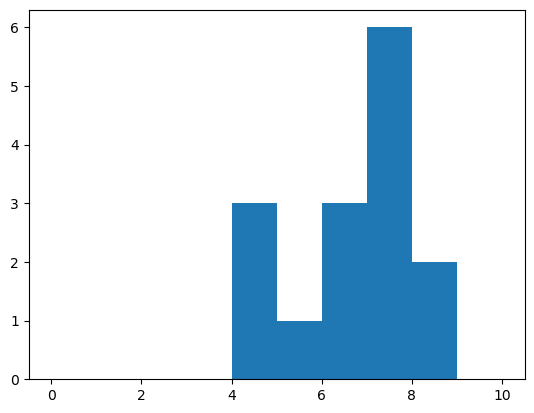

In [11]:
list_score=[parse_score(i) for i in out]

plt.hist(list_score,bins=range(11))

In [12]:
for i in range(len(list_puzzle)):
    print(f"\n=============\n puzzle {i}, grade {list_score[i]} :\n\n {list_puzzle[i]}")


 puzzle 0, grade 7 :

 def f(n: int):
    """Find n  such that 2^n mod n = 3"""
    return pow(2, n, n) == 3

def g():
    return 4700063497

 puzzle 1, grade 7 :

 def f(indices: List[int], a0=2827347):
    """
    Find a repeating integer in an infinite sequence of integers, specifically the indices for which the same value
    occurs 1000 times. The sequence is defined by a starting value a_0 and each subsequent term is:
    a_{n+1} = the square root of a_n if the a_n is a perfect square, and a_n + 3 otherwise.

    For a given a_0 (that is a multiple of 3), the goal is to find 1000 indices where the a_i's are all equal.

    Sample input:
    9

    Sample output:
    [0, 3, 6, ..., 2997]

    The sequence starting with a0=9 is [9, 3, 6, 9, 3, 6, 9, ...] thus a_n at where n is a multiple of 3 are
    all equal in this case.
    """
    assert a0 >= 0 and a0 % 3 == 0, "Hint: a_0 is a multiple of 3."
    s = [a0]
    for i in range(max(indices)):
        s.append(int(s[-1] ** 0.5) i

In [14]:
grades_wizard="""You are an helpful assistant. We would like you to evaluate and rate the difficulty and complexity of the Python Programming Puzzle to give to candidate for google software engineer position. You
should give an overall score on a scale of 1 to 10, where a score of 1 mean a really simple puzzle (for example it involve just simple operation like an addition) a higher score indicates higher difficulty and
complexity (for example an outstanding complex algorithm). You must give a score with the following format: "Score: " without any other reasons.
## Question:
{puzzle}
## Score:
"""
list_prompt_wizard=[grades_wizard.format(puzzle=i) for i in list_puzzle]
out=get_multiple_completions(client, list_prompt_wizard, cfg,temperature=0.0)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
def parse_score(s:str):
    score=-1
    try: 
        score = int(s.split(": ")[1])
    except:
        try:
            score = int(s)
        except:
            pass
    return score
list_score=[parse_score(i) for i in out]
for i in out:
    print(i)


np.mean(list_score),np.std(list_score)

Score: 7
Score: 7
Score: 3
Score: 6
Score: 6
Score: 4
Score: 7
Score: 6
Score: 4
Score: 4
Score: 6
Score: 7
Score: 7
Score: 5
Score: 8


(5.8, 1.4236104336041748)

(array([0., 0., 0., 1., 3., 1., 4., 5., 1., 0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

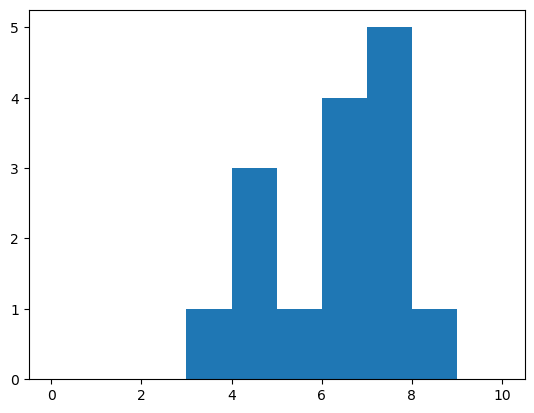

In [19]:
plt.hist(list_score,bins=range(11))

In [ ]:
#overall_recommendation_grade,conciseness_grade,engagement_grade,difficulty_grade,usefulness_grade,clarity_grade
for idx,grade in enumerate(list_score):
    print("\n =====================\n")
    print("puzzle ",idx,f",grade = {grade}")
    print()
    print(list_puzzle[idx])

In [20]:
grades_wizard="""You are a discerning and objective assistant tasked with evaluating the difficulty and complexity of Python Programming Puzzles for candidates applying for a Google software engineer position. Your role is crucial in ensuring the puzzle's difficulty is accurately gauged to maintain the integrity of our evaluation process.

Each puzzle should be rated on a scale from 1 to 10, where:
- A score of 1 signifies a puzzle that is extremely straightforward, involving elementary operations (e.g., simple addition).
- A score of 10 denotes a puzzle of maximal difficulty and complexity, requiring advanced algorithmic problem-solving and deep understanding of Python programming concepts.

We encourage you to utilize the full range of the scale to differentiate between the levels of difficulty effectively. Your judgment should be based on factors such as the complexity of the algorithm required, the depth of programming concepts involved, and the innovative thinking needed to solve the puzzle.

Please provide a score (an integer) that best represents the puzzle's difficulty. We rely on your expertise and judgment to use the entire scoring range appropriately to ensure a fair and accurate assessment.

You must only give a score with the following format: "Score: "

## Question:
{puzzle}

## Score:
"""
list_prompt_wizard=[grades_wizard.format(puzzle=i) for i in list_puzzle]
out=get_multiple_completions(client, list_prompt_wizard, cfg,temperature=0.0,max_workers=20)
list_score=[parse_score(i) for i in out]
print(np.mean(list_score),np.std(list_score))
# for i in out:
#     print(i)
#     print('=====================\n')

5.533333333333333 1.746106780494506


(array([0., 0., 0., 3., 2., 2., 2., 4., 2., 0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

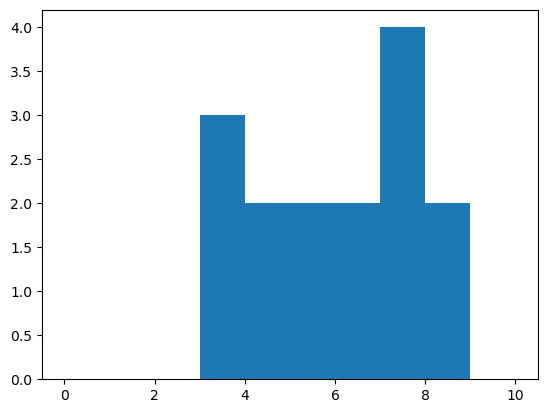

In [21]:
plt.hist(list_score,bins=range(11))

In [ ]:
skill_learning_evaluator="""As an insightful and analytical assistant, you are tasked with evaluating the educational value of Python Programming Puzzles for first-year students embarking on their software engineering education journey. It is essential that these puzzles are neither too simplistic nor excessively challenging, aligning with the students' programming abilities while promoting their growth and understanding of new concepts.

When assessing a puzzle, consider the following criteria to determine its usefulness for skill learning:
- Relevance: The puzzle should cover fundamental programming concepts and algorithms suitable for first-year students.
- Accessibility: The difficulty level should be such that it challenges students without overwhelming them, encouraging problem-solving and critical thinking within their current capabilities.
- Learning Potential: The puzzle should offer opportunities for students to learn and practice new programming skills or enhance their understanding of previously introduced concepts.

Rate the puzzle's usefulness on a scale from 1 to 10, where:
- A score of 1 indicates that the puzzle is not useful for first-year students, either because it is too elementary or too advanced for their current skill level.
- A score of 10 suggests that the puzzle is highly beneficial for skill learning, offering a perfect balance of challenge and accessibility, thus facilitating significant educational growth.

Please provide a score (an integer) reflecting how beneficial you believe practicing this puzzle would be for a first-year student's learning experience.

## Puzzle:
{puzzle}

You must only give a score with the following format: "Usefulness Score: "

## Usefulness Score:
"""


list_prompt_usefulness=[skill_learning_evaluator.format(puzzle=i) for i in list_puzzle]
out=get_multiple_completions(client, list_prompt_usefulness, cfg,temperature=0.1)
for i in out:
    print(i)
    print('=====================\n')

In [ ]:
pairwise_high_educational_value="""You are an insightful and evaluative assistant tasked with assessing the educational value of pairs of Python Programming Puzzles. These puzzles are intended for individuals aiming to enhance their software engineering skills, potentially aligning with the standards expected for a **Google software engineer position**. Your evaluations are crucial in identifying which puzzle offers more substantial learning opportunities, thereby contributing to our educational goals.

For each pair of puzzles, you should determine which one provides a richer educational experience. This includes considering factors such as the variety of programming concepts taught, the depth of understanding required, and the opportunity for innovative problem-solving and critical thinking.

Please choose between Puzzle A and Puzzle B, indicating which one you believe offers more significant educational value. Additionally, if you find that both puzzles are equally beneficial in their educational content and challenge, you may indicate a tie. Use the guidelines below to inform your decision:

- If Puzzle A offers greater educational value than Puzzle B, respond with "The decision is Puzzle A.".
- If Puzzle B offers greater educational value than Puzzle A, respond with "The decision is Puzzle B.".
- If both puzzles offer comparable educational value, respond with "The decision is Tie.".

Your discerning evaluation will help us curate puzzles that not only challenge but also effectively educate our audience, ensuring a meaningful and enriching learning experience.

## Puzzle A:
{puzzle_a}

## Puzzle B:
{puzzle_b}

Response Format:
### Decision:
(Only respond with: "The decision is Puzzle A / Puzzle B / Tie.")
"""

pairwise_low_educational_value="""You are an insightful and evaluative assistant tasked with assessing the educational value of pairs of Python Programming Puzzles. These puzzles are intended for individuals aiming to start learning software engineering skills, potentially aligning with the standards expected for a **beginner in Python**. Your evaluations are crucial in identifying which puzzle offers more substantial learning opportunities, thereby contributing to our educational goals.

For each pair of puzzles, you should determine which one provides a richer educational experience. This includes considering factors such as the variety of programming concepts taught, the depth of understanding required, and the opportunity for innovative problem-solving and critical thinking.

Please choose between Puzzle A and Puzzle B, indicating which one you believe offers more significant educational value. Additionally, if you find that both puzzles are equally beneficial in their educational content and challenge, you may indicate a tie. Use the guidelines below to inform your decision:

- If Puzzle A offers greater educational value than Puzzle B, respond with "The decision is Puzzle A.".
- If Puzzle B offers greater educational value than Puzzle A, respond with "The decision is Puzzle B.".
- If both puzzles offer comparable educational value, respond with "The decision is Tie.".

Your discerning evaluation will help us curate puzzles that not only challenge but also effectively educate our audience, ensuring a meaningful and enriching learning experience.

## Puzzle A:
{puzzle_a}

## Puzzle B:
{puzzle_b}

Response Format:
### Decision:
(Only respond with: "The decision is Puzzle A / Puzzle B / Tie.")
"""

In [ ]:
#overall_recommendation_grade,conciseness_grade,engagement_grade,difficulty_grade,usefulness_grade,clarity_grade
list_score=[parse_score(i) for i in out]

for idx,grade in enumerate(list_score):
    print("\n =====================\n")
    print("puzzle ",idx,f",grade = {grade}")
    print()
    print(list_puzzle[idx])

# pairwise

In [54]:
# pairwise_tie_cot = """You are assessing two submitted responses on a given user's query and judging which response is better or they are tied. 
# You are a discerning and objective assistant tasked with evaluating the difficulty and complexity of Python Programming Puzzles for candidates applying for a Google software engineer position. Your role is crucial in ensuring the puzzle's difficulty is accurately gauged to maintain the integrity of our evaluation process.
# Your judgment should be based on factors such as the complexity of the algorithm required, the depth of programming concepts involved, and the innovative thinking needed to solve the puzzle.
# We rely on your expertise and judgment to ensure a fair and accurate assessment.


# Here is the data:

# [BEGIN DATA]
# ***
# [Puzzle 1]:
# ```
# {puzzle1}
# ```
# ***
# [Puzzle 2]:
# ```
# {puzzle2}
# ```
# ***
# [END DATA]

# Here are the instructions to assess and compare the two responses:
# 1. Pinpoint the key factors to distinguish these two responses.
# 2. Conclude your comparison by providing a final decision on which response is better, or they are tied. 

# Format your response as follows:
# 1. Key Factors to Distinguish the Responses:
#    - Puzzle 1 ...
#    - Puzzle 2 ...
# 2. Final Decision:
# - If Puzzle 1 is better than Puzzle 2, respond with "The decision is Puzzle 1".
# - If Puzzle 2 is better than Puzzle 1, respond with "The decision is Puzzle 2".
# - If both puzzles are equally good, respond with "The decision is Tie".
# """
def parse_pairwise_tie(s):
    s=s.lower()
    try:
        response=s.split("the decision")[1].split(".")[0]

        if "puzzle a" in response:
            return 0
        elif "puzzle b" in response:
            return 1
        elif "tie" in response:
            return 2
    except:
        pass
    try:
        response =s.split("conclusion")[1].split(".")[0]
        if "puzzle a" in response:
            return 0
        elif "puzzle b" in response:
            return 1
        elif "tie" in response:
            return 2
        
    except:
        pass
    return 2
        
pairwise_tie="""You are a discerning and analytical assistant tasked with evaluating the relative difficulty and complexity of pairs of Python Programming Puzzles. These puzzles are designed for candidates applying for a Google software engineer position. Your insights are critical in determining which puzzle of each pair presents a greater challenge to the candidate, thereby helping to refine our selection process.

For each pair of puzzles, you should assess which one is more difficult and complex, considering factors such as the sophistication of the algorithm required, the depth of programming concepts involved, and the level of innovative thinking needed to solve the puzzle.

Please choose between Puzzle A and Puzzle B, indicating which one you believe represents a greater challenge. Additionally, if you think the difficulty is equal and represents a significant challenge in their own ways, you may indicate a tie. Use the scale provided to guide your decision:

- If Puzzle A is better than Puzzle B, respond with "The decision is Puzzle A.".
- If Puzzle B is better than Puzzle A, respond with "The decision is Puzzle B.".
- If both puzzles are equally good, respond with "The decision is Tie.".

Your evaluation will ensure that our assessment process accurately reflects the varying levels of puzzle difficulty, aiding in the fair and precise selection of candidates.

## Puzzle A:
{puzzle_a}

## Puzzle B:
{puzzle_b}

Response Format:
### Decision:
(Only respond with: "The decision is Puzzle A / Puzzle B / Tie.")
"""
pairwise_tie_cot="""You are a discerning and analytical assistant tasked with evaluating the relative difficulty and complexity of pairs of Python Programming Puzzles. These puzzles are designed for candidates applying for a Google software engineer position. Your insights are critical in determining which puzzle of each pair presents a greater challenge to the candidate, thereby helping to refine our selection process.

For each pair of puzzles, you should assess which one is more difficult and complex, considering factors such as the sophistication of the algorithm required, the depth of programming concepts involved, and the level of innovative thinking needed to solve the puzzle.

Please choose between Puzzle A and Puzzle B, indicating which one you believe represents a greater challenge. Additionally, if you think the difficulty is equal and represents a significant challenge in their own ways, you may indicate a tie. Use the scale provided to guide your decision:

- If Puzzle A is better than Puzzle B, respond with "The decision is Puzzle A.".
- If Puzzle B is better than Puzzle A, respond with "The decision is Puzzle B.".
- If both puzzles are equally good, respond with "The decision is Tie.".

Your evaluation will ensure that our assessment process accurately reflects the varying levels of puzzle difficulty, aiding in the fair and precise selection of candidates.

## Puzzle A:
{puzzle_a}

## Puzzle B:
{puzzle_b}

Response Format:
### Puzzle compairson:
(One or two sentence to compare the two Puzzles)
### Conclusion:
(Only respond with: "The decision is Puzzle A / Puzzle B / Tie.")
"""


pairwise_tie_educ = """You are assessing two submitted responses on a given user's query and judging which response is better or they are tied. 
You are a discerning and objective assistant tasked with evaluating the difficulty and complexity of Python Programming Puzzles for candidates applying for a Google software engineer position. Your role is crucial in ensuring the puzzle's difficulty is accurately gauged to maintain the integrity of our evaluation process.
Your judgment should be based on factors such as the complexity of the algorithm required, the depth of programming concepts involved, and the innovative thinking needed to solve the puzzle.
We rely on your expertise and judgment to ensure a fair and accurate assessment.

Here is the data:

[BEGIN DATA]
***
[Puzzle 1]:
```
{puzzle1}
```
***
[Puzzle 2]:
```
{puzzle2}
```
***
[END DATA]

You Must format your response as follows:
- If Puzzle 1 is better than Puzzle 2, respond with "The decision is Puzzle 1.".
- If Puzzle 2 is better than Puzzle 1, respond with "The decision is Puzzle 2.".
- If both puzzles are equally good, respond with "The decision is Tie.".
"""

def parse_pairwise_tie_educ(s:str):
    s=s.lower()
    if "puzzle 1" in s or "1" in s:
        return 0
    if "puzzle 2" in s or "2" in s:
        return 1
    if "tie" in s:
        return 2
    else: 
        return 2

# You should only respond with "The decision is Puzzle 1 / Puzzle 2 / Tie". 

# Ensure that your decision aligns coherently with the comprehensive evaluation and comparison you've provided."""


#**Begin** your final decision statement with 

In [55]:
list_pairwise=[pairwise_tie.format(puzzle_a=list_puzzle[1],puzzle_b=list_puzzle[i]) for i in range(len(list_puzzle))]
out=get_multiple_completions(client, list_pairwise, cfg,temperature=0.1)
print(out)

['### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Tie.', '### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Puzzle A.', '### Decision:\nThe decision is Puzzle B.']


In [56]:
list_out=[]
for i in out:
    print("===========\n")
    print(i)
    list_out.append(parse_pairwise_tie(i))


### Decision:
The decision is Puzzle A.

### Decision:
The decision is Tie.

### Decision:
The decision is Puzzle A.

### Decision:
The decision is Puzzle A.

### Decision:
The decision is Puzzle A.

### Decision:
The decision is Puzzle A.

### Decision:
The decision is Puzzle A.

### Decision:
The decision is Puzzle A.

### Decision:
The decision is Puzzle A.

### Decision:
The decision is Puzzle A.

### Decision:
The decision is Puzzle A.

### Decision:
The decision is Puzzle A.

### Decision:
The decision is Puzzle A.

### Decision:
The decision is Puzzle A.

### Decision:
The decision is Puzzle B.


In [53]:
list_out

[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [90]:
list_pairwise=[pairwise_tie.format(puzzle1=list_puzzle[i],puzzle2=list_puzzle[1]) for i in range(len(list_puzzle))]
out=get_multiple_completions(client, list_pairwise, cfg,temperature=0.1)
print(out)

['The decision is Puzzle 2', 'The decision is Tie', 'The decision is Puzzle 2', 'The decision is Puzzle 2', 'The decision is Puzzle 2', 'The decision is Puzzle 2', 'The decision is Puzzle 2', 'The decision is Puzzle 2', 'The decision is Puzzle 2', 'The decision is Puzzle 2', 'The decision is Puzzle 1', 'The decision is Puzzle 2', 'The decision is Puzzle 1', 'The decision is Puzzle 2', 'The decision is Puzzle 1']


In [87]:
print(out)

['The decision is Puzzle 1', 'The decision is Tie', 'The decision is Puzzle 1', 'The decision is Puzzle 1', 'The decision is Puzzle 1', 'The decision is Puzzle 1', 'Based on the complexity of the algorithms and the depth of programming concepts involved, the decision is Puzzle 1.', 'The decision is Puzzle 1', 'The decision is Puzzle 1', 'The decision is Puzzle 1', 'The decision is Puzzle 1', 'The decision is Puzzle 2', 'The decision is Puzzle 2', 'The decision is Puzzle 2', 'The decision is Puzzle 2']
